In [1]:
from __future__ import division
from __future__ import print_function

import sys, os, gc
import tensorflow as tf
import numpy as np
from sklearn import linear_model
from sklearn.metrics import roc_curve, auc

sys.path.append('../')
os.environ["CUDA_VISIBLE_DEVICES"] = "1"

from models.neural_network import NeuralNetwork
from models.cnn import CNN
from models.util import *


#Seed used for choosing classes, training points, and test points.
SEED = 7



Using TensorFlow backend.


In [2]:
#Define params of model
input_shape = (32,32,3)
num_classes = 2
eps=0.15


In [3]:
#Load model from disk
model_name = 'CIFAR2'
model_save_path = '../trained_models/' + model_name + '-model.json'
weights_save_path = '../trained_models/' + model_name + 'weights'
model = CNN(model_name=model_name, dataset='cifar2', seed=SEED)
print ('Total Model Params: %d' % model.num_params)
model.load_model(model_save_path, weights_save_path) 
#epochs = 150
#model.train(epochs=epochs)
#model.save_model(model_save_path, weights_save_path)   

Using classes: 4, and 9
Total Model Params: 16797378
Loaded model from disk


In [4]:
#Model Accuracy
print ('Model Accuracy: %.5f' % (model.model.evaluate(model.test_data, model.test_labels)[1]))

1218/1218 [==============================] - 1s 778us/step
Model Accuracy: 0.97373


In [5]:
#Get training samples
num_train_samples = 1000
data_indices = model.gen_rand_indices(low=0, high=model.train_data.shape[0], seed=SEED, num_samples=num_train_samples)
train_data = model.train_data[data_indices]
train_data_labels = model.train_labels[data_indices]
train_data_labels_int = np.argmax(train_data_labels, axis=1)

In [6]:
num_test_samples_per_class = 250
num_test_samples = num_classes*num_test_samples_per_class

#Generate test points
test_indices = model.gen_rand_indices_all_classes(y=model.test_labels, seed=SEED, num_samples=num_test_samples_per_class)

#Get Regular, Noisy, FGSM, BIM, and CW test points
reg_data = model.test_data[test_indices]
fgsm_data = model.generate_perturbed_data(model.test_data[test_indices], model.test_labels[test_indices],seed=SEED, perturbation='FGSM', eps=eps)
bim_a_data = model.generate_perturbed_data(model.test_data[test_indices], model.test_labels[test_indices], seed=SEED, perturbation='BIM-A', iterations=10, eps=eps)
bim_b_data = model.generate_perturbed_data(model.test_data[test_indices], model.test_labels[test_indices], seed=SEED, perturbation='BIM-B', iterations=10, eps=eps)
cw_data = model.generate_perturbed_data(model.test_data[test_indices], model.test_labels[test_indices],seed=SEED, perturbation='CW', targeted=False, eps=eps)
df_data = model.generate_perturbed_data(model.test_data[test_indices], model.test_labels[test_indices],seed=SEED, perturbation='DF', nb_candidate=num_classes)
jsma_data = model.generate_perturbed_data(model.test_data[test_indices], model.test_labels[test_indices],seed=SEED, perturbation='JSMA')

/root/notebook/cleverhans/cleverhans/src/cleverhans/cleverhans/utils_keras.py:144: UserWarning: Please update your version to keras >= 2.1.3; support for earlier keras versions will be dropped on 2018-07-22
  "Please update your version to keras >= 2.1.3; "


In [7]:
#Reset tf.graph() as Cleverhans modifies the graph
tf.reset_default_graph()

#Reload the model and weights
model = CNN(model_name=model_name, dataset='cifar2', seed=SEED)
model.load_model(model_save_path, weights_save_path)    


Using classes: 4, and 9
Loaded model from disk


In [8]:
fgsm_guides = model.model.predict(fgsm_data.reshape(-1,*input_shape))
bim_a_guides = model.model.predict(bim_a_data.reshape(-1,*input_shape))
bim_b_guides = model.model.predict(bim_a_data.reshape(-1,*input_shape))

#Whitebox CW Attack
#First get guide images
guide_indices_fgsm = list()
guide_indices_bim_a = list()
guide_indices_bim_b = list()
np.random.seed(SEED)
#Generate guide images for modified CW attacks
for i in range(num_test_samples):
    label_fgsm = np.argmax(fgsm_guides[i])
    label_bim_a = np.argmax(bim_a_guides[i])
    label_bim_b = np.argmax(bim_b_guides[i])
   
    #Get a test point with the target label
    guide_imgs_indices_fgsm = np.where(model.train_labels[:,label_fgsm] == 1)[0]
    guide_imgs_indices_bim_a = np.where(model.train_labels[:,label_bim_a] == 1)[0]
    guide_imgs_indices_bim_b = np.where(model.train_labels[:,label_bim_b] == 1)[0]
    #Choose a guide image
    guide_img_idx_fgsm = np.random.choice(guide_imgs_indices_fgsm, 1)[0]
    guide_img_idx_bim_a = np.random.choice(guide_imgs_indices_bim_a, 1)[0]
    guide_img_idx_bim_b = np.random.choice(guide_imgs_indices_bim_b, 1)[0]


    guide_indices_fgsm.append(guide_img_idx_fgsm)
    guide_indices_bim_a.append(guide_img_idx_bim_a)
    guide_indices_bim_b.append(guide_img_idx_bim_b)


#1 Phase Attack
fgsm_wb_data = model.generate_perturbed_data(model.test_data[test_indices], model.test_labels[test_indices],seed=SEED, perturbation='FGSM-WB', eps=eps, x_tar=model.train_data[guide_indices_fgsm], y_tar = model.train_labels[guide_indices_fgsm])
bim_a_wb_data = model.generate_perturbed_data(model.test_data[test_indices], model.test_labels[test_indices],seed=SEED, perturbation='BIM-A-WB', eps=eps, x_tar=model.train_data[guide_indices_bim_a], y_tar = model.train_labels[guide_indices_bim_a])
bim_b_wb_data = model.generate_perturbed_data(model.test_data[test_indices], model.test_labels[test_indices],seed=SEED, perturbation='BIM-B-WB', eps=eps, x_tar=model.train_data[guide_indices_bim_b], y_tar = model.train_labels[guide_indices_bim_b])

In [9]:
#Reset tf.graph() as Cleverhans modifies the graph
tf.reset_default_graph()

#Reload the model and weights
model = CNN(model_name=model_name, dataset='cifar2', seed=SEED)
model.load_model(model_save_path, weights_save_path)  


Using classes: 4, and 9
Loaded model from disk


In [10]:
#Whitebox CW Attack
#First get guide images
guide_indices = list()
np.random.seed(SEED)
#Generate guide images for modified CW attacks
for idx in test_indices:
    label = np.argmax(model.test_labels[idx])
    #Add 1 to the label mod 10 to get a target label
    mod_label = (label + 1) % num_classes
    #Get a test point with the target label
    guide_imgs_indices = np.where(model.train_labels[:,mod_label] == 1)[0]
    #Choose a guide image
    guide_img_idx = np.random.choice(guide_imgs_indices, 1)[0]
    guide_indices.append(guide_img_idx)


#1 Phase Attack
p1_cw_data = model.generate_perturbed_data(model.test_data[test_indices], y_tar=model.train_labels[guide_indices],seed=SEED, perturbation='CW', targeted=True, x_tar = model.train_data[guide_indices], use_cos_norm_reg=True, eps=eps)

#2 Phase Attack 
#Phase 1: Generate targeted adversarial images 
tar_cw_data = model.generate_perturbed_data(model.test_data[test_indices], y_tar=model.train_labels[guide_indices],seed=SEED, perturbation='CW', targeted=True, use_cos_norm_reg=False, eps=eps)
#Phase 2: Optimize for higher cosine sim and smaller norm of gradient vector
p2_cw_data = model.generate_perturbed_data(tar_cw_data, y_tar=model.train_labels[guide_indices],seed=SEED, perturbation='CW', targeted=True, x_tar = model.train_data[guide_indices], use_cos_norm_reg=True, eps=eps)

In [11]:
#Reset tf.graph() as Cleverhans modifies the graph
tf.reset_default_graph()

#Reload the model and weights
model = CNN(model_name=model_name, dataset='cifar2', seed=SEED)
model.load_model(model_save_path, weights_save_path)  


Using classes: 4, and 9
Loaded model from disk


In [12]:
#Whitebox CW 2 Phase attack with FGSM, BIM-a/b guide images
p2_cw_fgsm_data = model.generate_perturbed_data(fgsm_data, y_tar=model.train_labels[guide_indices_fgsm],seed=SEED, perturbation='CW', targeted=True, x_tar = model.train_data[guide_indices_fgsm], use_cos_norm_reg=True, eps=eps)
p2_cw_bim_a_data = model.generate_perturbed_data(bim_a_data, y_tar=model.train_labels[guide_indices_bim_a],seed=SEED, perturbation='CW', targeted=True, x_tar = model.train_data[guide_indices_bim_a], use_cos_norm_reg=True, eps=eps)
p2_cw_bim_b_data = model.generate_perturbed_data(bim_b_data, y_tar=model.train_labels[guide_indices_bim_b],seed=SEED, perturbation='CW', targeted=True, x_tar = model.train_data[guide_indices_bim_b], use_cos_norm_reg=True, eps=eps)

In [13]:
#Reset tf.graph() as Cleverhans modifies the graph
tf.reset_default_graph()

#Reload the model and weights
model = CNN(model_name=model_name, dataset='cifar2', seed=SEED)
model.load_model(model_save_path, weights_save_path)  

Using classes: 4, and 9
Loaded model from disk


In [14]:
print ('Model Accuracy REG: %.5f' % (model.model.evaluate(reg_data,model.test_labels[test_indices])[1]))
print ('Model Accuracy FGSM: %.5f' % (model.model.evaluate(fgsm_data,model.test_labels[test_indices])[1]))
print ('Model Accuracy BIM-A: %.5f' % (model.model.evaluate(bim_a_data,model.test_labels[test_indices])[1]))
print ('Model Accuracy BIM-B: %.5f' % (model.model.evaluate(bim_b_data,model.test_labels[test_indices])[1]))
print ('Model Accuracy CW: %.5f' % (model.model.evaluate(cw_data,model.test_labels[test_indices])[1]))
print ('Model Accuracy DF: %.5f' % (model.model.evaluate(df_data,model.test_labels[test_indices])[1]))
print ('Model Accuracy JSMA: %.5f' % (model.model.evaluate(jsma_data,model.test_labels[test_indices])[1]))
print ('Model Accuracy FGSM-WB: %.5f' % (model.model.evaluate(fgsm_wb_data,model.test_labels[test_indices])[1]))
print ('Model Accuracy BIM-A WB: %.5f' % (model.model.evaluate(bim_a_wb_data,model.test_labels[test_indices])[1]))
print ('Model Accuracy BIM-B WB: %.5f' % (model.model.evaluate(bim_b_wb_data,model.test_labels[test_indices])[1]))
print ('Model Accuracy P1 CW: %.5f' % (model.model.evaluate(p1_cw_data,model.test_labels[test_indices])[1]))
print ('Model Accuracy P2 CW: %.5f' % (model.model.evaluate(p2_cw_data,model.test_labels[test_indices])[1]))
print ('Model Accuracy P2 FGSM: %.5f' % (model.model.evaluate(p2_cw_fgsm_data,model.test_labels[test_indices])[1]))
print ('Model Accuracy P2 BIM-A: %.5f' % (model.model.evaluate(p2_cw_bim_a_data,model.test_labels[test_indices])[1]))
print ('Model Accuracy P2 BIM-B %.5f' % (model.model.evaluate(p2_cw_bim_b_data,model.test_labels[test_indices])[1]))


500/500 [==============================] - 0s 379us/step
Model Accuracy REG: 0.97600
500/500 [==============================] - 0s 291us/step
Model Accuracy FGSM: 0.00000
500/500 [==============================] - 0s 295us/step
Model Accuracy BIM-A: 0.00000
500/500 [==============================] - 0s 292us/step
Model Accuracy BIM-B: 0.00000
500/500 [==============================] - 0s 283us/step
Model Accuracy CW: 0.02400
500/500 [==============================] - 0s 285us/step
Model Accuracy DF: 0.02400
500/500 [==============================] - 0s 286us/step
Model Accuracy JSMA: 0.02400
500/500 [==============================] - 0s 290us/step
Model Accuracy FGSM-WB: 0.98800
500/500 [==============================] - 0s 296us/step
Model Accuracy BIM-A WB: 0.99600
500/500 [==============================] - 0s 294us/step
Model Accuracy BIM-B WB: 0.99600
500/500 [==============================] - 0s 285us/step
Model Accuracy P1 CW: 0.00000
500/500 [==============================] - 0s

In [15]:
#Get distortion
print ('FGSM: %.5f' % (avg_l2_dist(reg_data, fgsm_data)))
print ('BIM-A: %.5f' % (avg_l2_dist(reg_data, bim_a_data)))
print ('BIM-B: %.5f' % (avg_l2_dist(reg_data, bim_b_data)))
print ('CW: %.5f' % (avg_l2_dist(reg_data, cw_data)))
print ('DF: %.5f' % (avg_l2_dist(reg_data, df_data)))
print ('FGSM-WB: %.5f' % (avg_l2_dist(reg_data, fgsm_wb_data)))
print ('BIM-A-WB: %.5f' % (avg_l2_dist(reg_data, bim_a_wb_data)))
print ('BIM-B-WB: %.5f' % (avg_l2_dist(reg_data, bim_b_wb_data)))
print ('JSMA: %.5f' % (avg_l2_dist(reg_data, jsma_data)))
print ('P1-CW: %.5f' % (avg_l2_dist(reg_data, p1_cw_data)))
print ('P2-CW: %.5f' % (avg_l2_dist(reg_data, p2_cw_data)))
print ('P2-CW FGSM: %.5f' % (avg_l2_dist(reg_data, p2_cw_fgsm_data)))
print ('P2-CW BIM A: %.5f' % (avg_l2_dist(reg_data, p2_cw_bim_a_data)))
print ('P2-CW BIM B: %.5f' % (avg_l2_dist(reg_data, p2_cw_bim_b_data)))


FGSM: 8.06880
BIM-A: 1.50875
BIM-B: 6.34513
CW: 1.82277
DF: 1.03200
FGSM-WB: 8.03625
BIM-A-WB: 5.58176
BIM-B-WB: 5.59069
JSMA: 3.68900
P1-CW: 2.89605
P2-CW: 1.79222
P2-CW FGSM: 8.06879
P2-CW BIM A: 1.50875
P2-CW BIM B: 6.34513


Regular: 


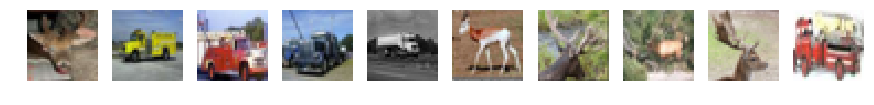

FGSM: 


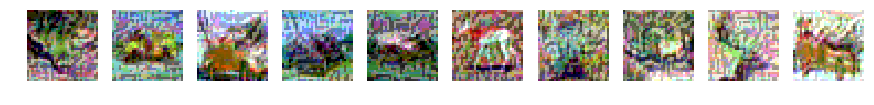

BIM-A: 


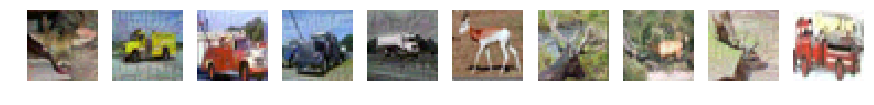

BIM-B: 


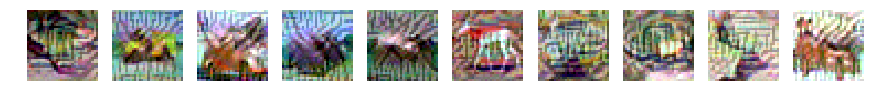

CW: 


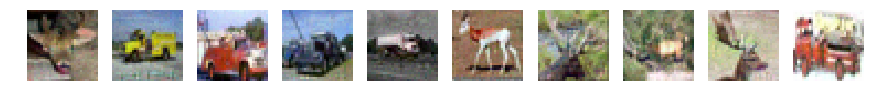

DF: 


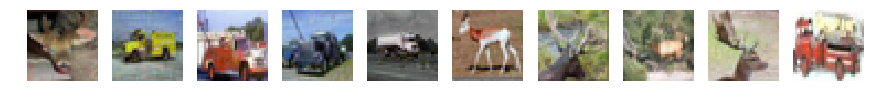

JSMA: 


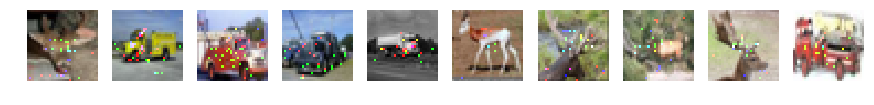

FGSM-WB: 


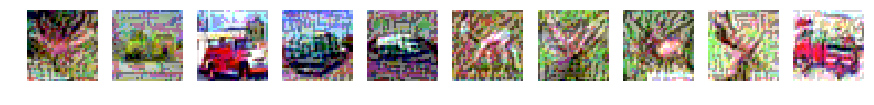

BIM-A-WB: 


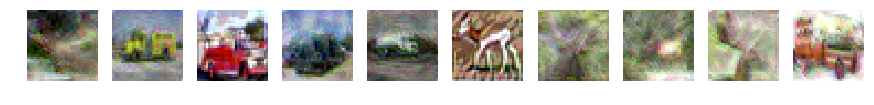

BIM-B-WB: 


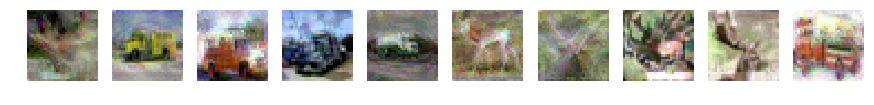

P1-CW: 


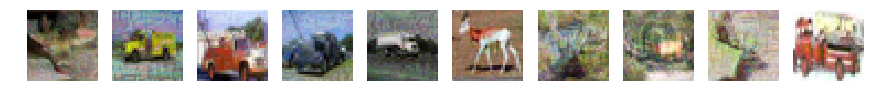

P2-CW: 


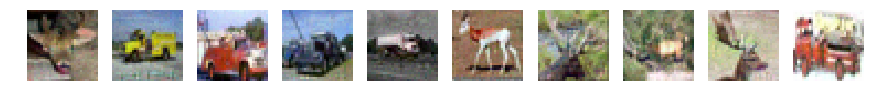

P2-FGSM: 


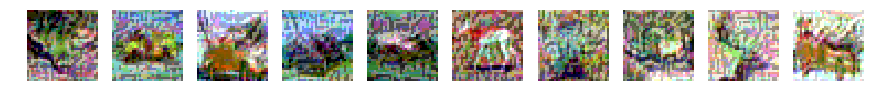

P2-BIM-A


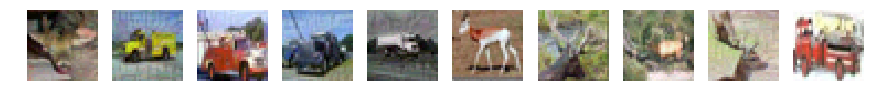

P2-BIM-B


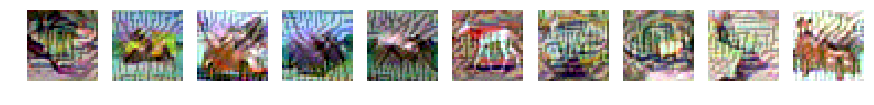

In [89]:
#Lets visualize one sample from each dataset
x_vis = np.random.choice(range(0,num_test_samples), 10)
print ('Regular: ')
visualize(reg_data[x_vis].reshape(-1,*input_shape), 10)
print ('FGSM: ')
visualize(fgsm_data[x_vis].reshape(-1,*input_shape), 10)
print ('BIM-A: ')
visualize(bim_a_data[x_vis].reshape(-1,*input_shape), 10)
print ('BIM-B: ')
visualize(bim_b_data[x_vis].reshape(-1,*input_shape), 10)
print ('CW: ')
visualize(cw_data[x_vis].reshape(-1,*input_shape), 10)
print ('DF: ')
visualize(df_data[x_vis].reshape(-1,*input_shape), 10)
print ('JSMA: ')
visualize(jsma_data[x_vis].reshape(-1,*input_shape), 10)
print ('FGSM-WB: ')
visualize(fgsm_wb_data[x_vis].reshape(-1,*input_shape), 10)
print ('BIM-A-WB: ')
visualize(bim_a_wb_data[x_vis].reshape(-1,*input_shape), 10)
print ('BIM-B-WB: ')
visualize(bim_b_wb_data[x_vis].reshape(-1,*input_shape), 10)
print ('P1-CW: ')
visualize(p1_cw_data[x_vis].reshape(-1,*input_shape), 10)
print ('P2-CW: ')
visualize(p2_cw_data[x_vis].reshape(-1,*input_shape), 10)
print ('P2-FGSM: ')
visualize(p2_cw_fgsm_data[x_vis].reshape(-1,*input_shape), 10)
print ('P2-BIM-A')
visualize(p2_cw_bim_a_data[x_vis].reshape(-1,*input_shape), 10)
print ('P2-BIM-B')
visualize(p2_cw_bim_b_data[x_vis].reshape(-1,*input_shape), 10)



In [17]:
#Get predictions
reg_preds = model.model.predict(reg_data.reshape(-1,*input_shape))
fgsm_preds = model.model.predict(fgsm_data.reshape(-1,*input_shape))
bim_a_preds = model.model.predict(bim_a_data.reshape(-1,*input_shape))
bim_b_preds = model.model.predict(bim_b_data.reshape(-1,*input_shape))
fgsm_wb_preds = model.model.predict(fgsm_wb_data.reshape(-1,*input_shape))
bim_a_wb_preds = model.model.predict(bim_a_wb_data.reshape(-1,*input_shape))
bim_b_wb_preds = model.model.predict(bim_a_wb_data.reshape(-1,*input_shape))
cw_preds = model.model.predict(cw_data.reshape(-1,*input_shape))
df_preds = model.model.predict(df_data.reshape(-1,*input_shape))
jsma_preds = model.model.predict(jsma_data.reshape(-1,*input_shape))
p1_cw_preds = model.model.predict(p1_cw_data.reshape(-1,*input_shape))
p2_cw_preds = model.model.predict(p2_cw_data.reshape(-1,*input_shape))
p2_cw_fgsm_preds = model.model.predict(p2_cw_fgsm_data.reshape(-1,*input_shape))
p2_cw_bim_a_preds = model.model.predict(p2_cw_bim_a_data.reshape(-1,*input_shape))
p2_cw_bim_b_preds = model.model.predict(p2_cw_bim_b_data.reshape(-1,*input_shape))


In [18]:
#Convert preds to labels
reg_labels = preds_to_labels(reg_preds)
fgsm_labels = preds_to_labels(fgsm_preds)
bim_a_labels = preds_to_labels(bim_a_preds)
bim_b_labels = preds_to_labels(bim_b_preds)
fgsm_wb_labels = preds_to_labels(fgsm_wb_preds)
bim_a_wb_labels = preds_to_labels(bim_a_wb_preds)
bim_b_wb_labels = preds_to_labels(bim_b_wb_preds)
cw_labels = preds_to_labels(cw_preds)
df_labels = preds_to_labels(df_preds)
jsma_labels = preds_to_labels(jsma_preds)
p1_cw_labels = preds_to_labels(p1_cw_preds)
p2_cw_labels = preds_to_labels(p2_cw_preds)
p2_cw_fgsm_labels = preds_to_labels(p2_cw_fgsm_preds)
p2_cw_bim_a_labels = preds_to_labels(p2_cw_bim_a_preds)
p2_cw_bim_b_labels = preds_to_labels(p2_cw_bim_b_preds)


In [46]:
#Select Adversarial Points (i.e. points that lead to misclassification)
true_preds = np.argmax(model.test_labels[test_indices], axis=1)

#Check which points are actually adversarial and select those
fgsm_idx = np.where(np.argmax(fgsm_preds, axis=1) != true_preds)[0]
bim_a_idx = np.where(np.argmax(bim_a_preds, axis=1) != true_preds)[0]
bim_b_idx = np.where(np.argmax(bim_b_preds, axis=1) != true_preds)[0]
fgsm_wb_idx =  np.where(np.argmax(fgsm_wb_preds, axis=1) != true_preds)[0]
bim_a_wb_idx = np.where(np.argmax(bim_a_wb_preds, axis=1) != true_preds)[0]
bim_b_wb_idx = np.where(np.argmax(bim_b_wb_preds, axis=1) != true_preds)[0]
cw_idx = np.where(np.argmax(cw_preds, axis=1) != true_preds)[0]
df_idx = np.where(np.argmax(df_preds, axis=1) != true_preds)[0]
jsma_idx = np.where(np.argmax(jsma_preds, axis=1) != true_preds)[0]
p1_cw_idx = np.where(np.argmax(p1_cw_preds, axis=1) != true_preds)[0]
p2_cw_idx = np.where(np.argmax(p2_cw_preds, axis=1) != true_preds)[0]
p2_cw_fgsm_idx = np.where(np.argmax(p2_cw_fgsm_preds, axis=1) != true_preds)[0]
p2_cw_bim_a_idx = np.where(np.argmax(p2_cw_bim_a_preds, axis=1) != true_preds)[0]
p2_cw_bim_b_idx = np.where(np.argmax(p2_cw_bim_b_preds, axis=1) != true_preds)[0]

In [20]:
#Filter data points to be used for similarity
fgsm_data_fil = fgsm_data[fgsm_idx]
bim_a_data_fil = bim_a_data[bim_a_idx]
bim_b_data_fil = bim_b_data[bim_b_idx]
fgsm_wb_data_fil = fgsm_wb_data[fgsm_wb_idx]
bim_a_wb_data_fil = bim_a_wb_data[bim_a_wb_idx]
bim_b_wb_data_fil = bim_b_wb_data[bim_b_wb_idx]
cw_data_fil = cw_data[cw_idx]
df_data_fil = df_data[df_idx]
jsma_data_fil = jsma_data[jsma_idx]
p1_cw_data_fil = p1_cw_data[p1_cw_idx]
p2_cw_data_fil = p2_cw_data[p2_cw_idx]
p2_cw_fgsm_data_fil = p2_cw_fgsm_data[p2_cw_fgsm_idx]
p2_cw_bim_a_data_fil = p2_cw_bim_a_data[p2_cw_bim_a_idx]
p2_cw_bim_b_data_fil = p2_cw_bim_b_data[p2_cw_bim_b_idx]

#Filter labels to be used
fgsm_labels_fil = fgsm_labels[fgsm_idx]
bim_a_labels_fil = bim_a_labels[bim_a_idx]
bim_b_labels_fil = bim_b_labels[bim_b_idx]
fgsm_wb_labels_fil = fgsm_wb_labels[fgsm_wb_idx]
bim_a_wb_labels_fil = bim_a_wb_labels[bim_a_wb_idx]
bim_b_wb_labels_fil = bim_b_wb_labels[bim_b_wb_idx]
cw_labels_fil = cw_labels[cw_idx]
df_labels_fil = df_labels[df_idx]
jsma_labels_fil = jsma_labels[jsma_idx]
p1_cw_labels_fil = p1_cw_labels[p1_cw_idx]
p2_cw_labels_fil = p2_cw_labels[p2_cw_idx]
p2_cw_fgsm_labels_fil = p2_cw_fgsm_labels[p2_cw_fgsm_idx]
p2_cw_bim_a_labels_fil = p2_cw_bim_a_labels[p2_cw_bim_a_idx]
p2_cw_bim_b_labels_fil = p2_cw_bim_b_labels[p2_cw_bim_b_idx]

In [21]:
#Get cosine similarity and norms
grads_train = model.get_gradients_wrt_params(train_data, train_data_labels)
grads_train = normalize(grads_train)
grads_reg_norms, cos_sim_reg = norms_and_cos(model, reg_data, reg_labels, grads_train)
grads_fgsm_norms, cos_sim_fgsm =norms_and_cos(model, fgsm_data_fil, fgsm_labels_fil, grads_train)
grads_bim_a_norms, cos_sim_bim_a = norms_and_cos(model, bim_a_data_fil, bim_a_labels_fil, grads_train)
grads_bim_b_norms , cos_sim_bim_b= norms_and_cos(model, bim_b_data_fil, bim_b_labels_fil, grads_train)
grads_fgsm_wb_norms, cos_sim_fgsm_wb = norms_and_cos(model, fgsm_wb_data_fil, fgsm_wb_labels_fil, grads_train)
grads_bim_a_wb_norms, cos_sim_bim_a_wb = norms_and_cos(model, bim_a_wb_data_fil, bim_a_wb_labels_fil, grads_train)
grads_bim_b_wb_norms, cos_sim_bim_b_wb = norms_and_cos(model, bim_b_wb_data_fil, bim_b_wb_labels_fil, grads_train)
grads_cw_norms, cos_sim_cw = norms_and_cos(model, cw_data_fil, cw_labels_fil, grads_train)
grads_df_norms, cos_sim_df = norms_and_cos(model, df_data_fil, df_labels_fil, grads_train)
grads_jsma_norms, cos_sim_jsma = norms_and_cos(model, jsma_data_fil, jsma_labels_fil, grads_train)
grads_p1_cw_norms, cos_sim_p1_cw = norms_and_cos(model, p1_cw_data_fil, p1_cw_labels_fil, grads_train)
grads_p2_cw_norms, cos_sim_p2_cw = norms_and_cos(model, p2_cw_data_fil, p2_cw_labels_fil, grads_train)
grads_p2_cw_fgsm_norms, cos_sim_p2_cw_fgsm = norms_and_cos(model, p2_cw_fgsm_data_fil, p2_cw_fgsm_labels_fil, grads_train)
grads_p2_cw_bim_a_norms, cos_sim_p2_cw_bim_a = norms_and_cos(model, p2_cw_bim_a_data_fil, p2_cw_bim_a_labels_fil, grads_train)
grads_p2_cw_bim_b_norms, cos_sim_p2_cw_bim_b = norms_and_cos(model, p2_cw_bim_b_data_fil, p2_cw_bim_b_labels_fil, grads_train)


../models/util.py:73: RuntimeWarning: invalid value encountered in sqrt
  norms = np.sqrt(np.dot(grads, grads.T)).diagonal()


In [23]:
#Ratio of perturbed samples having cos sim greater
print ('FGSM:  %.4f' % ( comp_cos(cos_sim_fgsm, cos_sim_reg)))
print ('BIM-A:  %.4f' % ( comp_cos(cos_sim_bim_a, cos_sim_reg)))
print ('BIM-B:  %.4f' % ( comp_cos(cos_sim_bim_b, cos_sim_reg)))
print ('CW: %.4f' % ( comp_cos(cos_sim_cw, cos_sim_reg)))
print ('DF: %.4f' % ( comp_cos(cos_sim_df, cos_sim_reg)))
print ('JSMA: %.4f' % ( comp_cos(cos_sim_jsma, cos_sim_reg)))
print ('FGSM-WB:  %.4f' % ( comp_cos(cos_sim_fgsm_wb, cos_sim_reg)))
print ('BIM-A-WB:  %.4f' % ( comp_cos(cos_sim_bim_a_wb, cos_sim_reg)))
print ('BIM-B-WB:  %.4f' % ( comp_cos(cos_sim_bim_b_wb, cos_sim_reg)))
print ('1 Phase CW:  %.4f' % ( comp_cos(cos_sim_p1_cw, cos_sim_reg)))
print ('2 Phase CW:  %.4f' % ( comp_cos(cos_sim_p2_cw, cos_sim_reg)))
print ('2 Phase CW FGSM:  %.4f' % ( comp_cos(cos_sim_p2_cw_fgsm, cos_sim_reg)))
print ('2 Phase CW BIM A:  %.4f' % ( comp_cos(cos_sim_p2_cw_bim_a, cos_sim_reg)))
print ('2 Phase CW BIM B:  %.4f' % ( comp_cos(cos_sim_p2_cw_bim_b, cos_sim_reg)))


FGSM:  0.2740
BIM-A:  0.2340
BIM-B:  0.2720
CW: 0.2111
DF: 0.2111
JSMA: 0.1926
FGSM-WB:  0.0000
BIM-A-WB:  0.0000
BIM-B-WB:  0.0000
1 Phase CW:  0.3360
2 Phase CW:  0.1740
2 Phase CW FGSM:  0.2740
2 Phase CW BIM A:  0.2340
2 Phase CW BIM B:  0.2720


In [24]:
#Ratio of perturbed samples having norm greater
print ('FGSM:  %.4f' % ( comp_norm(grads_fgsm_norms, grads_reg_norms)))
print ('BIM-A:  %.4f' % ( comp_norm(grads_bim_a_norms, grads_reg_norms)))
print ('BIM-B:  %.4f' % ( comp_norm(grads_bim_b_norms, grads_reg_norms)))
print ('CW: %.4f' % ( comp_norm(grads_cw_norms, grads_reg_norms)))
print ('DF: %.4f' % ( comp_norm(grads_df_norms, grads_reg_norms)))
print ('JSMA: %.4f' % ( comp_norm(grads_jsma_norms, grads_reg_norms)))
print ('FGSM-WB:  %.4f' % ( comp_norm(grads_fgsm_wb_norms, grads_reg_norms)))
print ('BIM-A-WB:  %.4f' % ( comp_norm(grads_bim_a_wb_norms, grads_reg_norms)))
print ('BIM-B-WB:  %.4f' % ( comp_norm(grads_bim_b_wb_norms, grads_reg_norms)))
print ('1 Phase CW: %.4f' % ( comp_norm(grads_p1_cw_norms, grads_reg_norms)))
print ('2 Phase CW: %.4f' % ( comp_norm(grads_p2_cw_norms, grads_reg_norms)))
print ('2 Phase CW FGSM: %.4f' % ( comp_norm(grads_p2_cw_fgsm_norms, grads_reg_norms)))
print ('2 Phase CW BIM A: %.4f' % ( comp_norm(grads_p2_cw_bim_a_norms, grads_reg_norms)))
print ('2 Phase CW BIM B: %.4f' % ( comp_norm(grads_p2_cw_bim_b_norms, grads_reg_norms)))


FGSM:  0.0640
BIM-A:  0.8920
BIM-B:  0.0020
CW: 0.9324
DF: 0.9754
JSMA: 0.9918
FGSM-WB:  0.5000
BIM-A-WB:  0.5000
BIM-B-WB:  0.5000
1 Phase CW: 0.6800
2 Phase CW: 0.9020
2 Phase CW FGSM: 0.0640
2 Phase CW BIM A: 0.8920
2 Phase CW BIM B: 0.0020


In [48]:
#Train a logistic regression classifier on the data. We only train on gray box attack points. 
#Due to lack of data (computationally expensive to compute attack points), we use 95% of data to train and 5% to test

#Select training and test indices
np.random.seed(SEED)
train_pct = .95
reg_train_idx = np.random.choice(np.arange(num_test_samples), int(train_pct*num_test_samples), replace=False)
reg_test_idx = get_test_from_train_idx(np.arange(num_test_samples), reg_train_idx)
fgsm_train_idx = np.random.choice(np.arange(len(fgsm_idx)), int(len(fgsm_idx)*train_pct), replace=False)
fgsm_test_idx = get_test_from_train_idx(np.arange(len(fgsm_idx)), fgsm_train_idx)
bim_a_train_idx = np.random.choice(np.arange(len(bim_a_idx)), int(len(bim_a_idx)*train_pct), replace=False)
bim_a_test_idx = get_test_from_train_idx(np.arange(len(bim_a_idx)), bim_a_train_idx)
bim_b_train_idx =np.random.choice(np.arange(len(bim_b_idx)), int(len(bim_b_idx)*train_pct), replace=False)
bim_b_test_idx = get_test_from_train_idx(np.arange(len(bim_b_idx)), bim_b_train_idx)
jsma_train_idx =np.random.choice(np.arange(len(jsma_idx)), int(len(jsma_idx)*train_pct), replace=False)
jsma_test_idx = get_test_from_train_idx(np.arange(len(jsma_idx)), jsma_train_idx)
cw_train_idx = np.random.choice(np.arange(len(cw_idx)), int(len(cw_idx)*train_pct), replace=False)
cw_test_idx = get_test_from_train_idx(np.arange(len(cw_idx)), cw_train_idx)
df_train_idx = np.random.choice(np.arange(len(df_idx)), int(len(df_idx)*train_pct), replace=False)
df_test_idx = get_test_from_train_idx(np.arange(len(df_idx)), df_train_idx)



# Set up training and test data for logistic regression
train_data = np.concatenate((cos_sim_reg[reg_train_idx], 
                             cos_sim_fgsm[fgsm_train_idx],
                             cos_sim_bim_a[bim_a_train_idx],
                             cos_sim_bim_b[bim_b_train_idx], 
                             cos_sim_jsma[jsma_train_idx], 
                             cos_sim_cw[cw_train_idx], 
                             cos_sim_df[df_train_idx]),axis=0)
train_labels = np.concatenate((np.zeros(len(reg_train_idx)), 
                               np.ones(len(fgsm_train_idx)),
                               np.ones(len(bim_a_train_idx)),
                               np.ones(len(bim_b_train_idx)),
                               np.ones(len(jsma_train_idx)),
                               np.ones(len(cw_train_idx)),
                               np.ones(len(df_train_idx))),axis=0)

test_data = np.concatenate((cos_sim_reg[reg_test_idx], 
                             cos_sim_fgsm[fgsm_test_idx],
                             cos_sim_bim_a[bim_a_test_idx],
                             cos_sim_bim_b[bim_b_test_idx], 
                             cos_sim_jsma[jsma_test_idx], 
                             cos_sim_cw[cw_test_idx], 
                             cos_sim_df[df_test_idx],
                             cos_sim_fgsm_wb,
                             cos_sim_bim_a_wb,
                             cos_sim_bim_b_wb,
                             cos_sim_p1_cw, 
                             cos_sim_p2_cw,
                             cos_sim_p2_cw_fgsm,
                             cos_sim_p2_cw_bim_a,
                             cos_sim_p2_cw_bim_b,),axis=0)

test_labels = np.concatenate((np.zeros(len(reg_test_idx)), 
                               np.ones(len(fgsm_test_idx)),
                               np.ones(len(bim_a_test_idx)),
                               np.ones(len(bim_b_test_idx)),
                               np.ones(len(jsma_test_idx)),
                               np.ones(len(cw_test_idx)),
                               np.ones(len(df_test_idx)),
                               np.ones(len(cos_sim_fgsm_wb)), 
                               np.ones(len(cos_sim_bim_a_wb)),
                               np.ones(len(cos_sim_bim_b_wb)),                               
                               np.ones(len(cos_sim_p1_cw)), 
                               np.ones(len(cos_sim_p2_cw)),
                               np.ones(len(cos_sim_p2_cw_fgsm)),
                               np.ones(len(cos_sim_p2_cw_bim_a)),
                               np.ones(len(cos_sim_p2_cw_bim_b,))),axis=0)

In [50]:
#Fit the data
logreg = linear_model.LogisticRegression(C=1e5)
logreg.fit(train_data, train_labels)


LogisticRegression(C=100000.0, class_weight=None, dual=False,
          fit_intercept=True, intercept_scaling=1, max_iter=100,
          multi_class='ovr', n_jobs=1, penalty='l2', random_state=None,
          solver='liblinear', tol=0.0001, verbose=0, warm_start=False)

In [51]:
#Get Accuracy for each attack type
fgsm_acc = logreg.score(cos_sim_fgsm[fgsm_test_idx], np.ones(len(fgsm_test_idx)))
bim_a_acc = logreg.score(cos_sim_bim_a[bim_a_test_idx], np.ones(len(bim_a_test_idx)))
bim_b_acc = logreg.score(cos_sim_bim_b[bim_b_test_idx], np.ones(len(bim_b_test_idx)))
jsma_acc = logreg.score(cos_sim_jsma[jsma_test_idx], np.ones(len(jsma_test_idx)))
cw_acc = logreg.score(cos_sim_cw[cw_test_idx], np.ones(len(cw_test_idx)))
df_acc = logreg.score(cos_sim_df[df_test_idx], np.ones(len(df_test_idx)))
fgsm_wb_acc = logreg.score(cos_sim_fgsm_wb, np.ones(len(cos_sim_fgsm_wb)))
bim_a_wb_acc = logreg.score(cos_sim_bim_a_wb, np.ones(len(cos_sim_bim_b_wb)))
bim_b_wb_acc = logreg.score(cos_sim_bim_b_wb, np.ones(len(cos_sim_bim_a_wb)))
p1_cw_acc = logreg.score(cos_sim_p1_cw, np.ones(len(cos_sim_p1_cw)))
p2_cw_acc = logreg.score(cos_sim_p2_cw, np.ones(len(cos_sim_p2_cw)))
p2_cw_fgsm_acc = logreg.score(cos_sim_p2_cw_fgsm, np.ones(len(cos_sim_p2_cw_fgsm)))
p2_cw_bim_a_acc = logreg.score(cos_sim_p2_cw_bim_a, np.ones(len(cos_sim_p2_cw_bim_a)))
p2_cw_bim_b_acc = logreg.score(cos_sim_p2_cw_bim_b, np.ones(len(cos_sim_p2_cw_bim_b)))

#Get Total accuracy
total_acc = logreg.score(test_data, test_labels)


In [52]:
print ('FGSM Detection Acc: %.5f' % (fgsm_acc))
print ('BIM-A Detection Acc: %.5f' % (bim_a_acc))
print ('BIM-B Detection Acc: %.5f' % (bim_b_acc))
print ('JSMA Detection Acc: %.5f' % (jsma_acc))
print ('CW Detection Acc: %.5f' % (cw_acc))
print ('DF Detection Acc: %.5f' % (df_acc))
print ('FGSM-WB Detection Acc: %.5f' % (fgsm_wb_acc))
print ('BIM-A-WB Detection Acc: %.5f' % (bim_a_wb_acc))
print ('BIM-B-WB Detection Acc: %.5f' % (bim_b_wb_acc))
print ('P1 CW Detection Acc: %.5f' % (p1_cw_acc))
print ('P2 CW Detection Acc: %.5f' % (p2_cw_acc))
print ('P2 CW FGSM Detection Acc: %.5f' % (p2_cw_fgsm_acc))
print ('P2 CW BIM-A Detection Acc: %.5f' % (p2_cw_bim_a_acc))
print ('P2 CW BIM-B Detection Acc: %.5f' % (p2_cw_bim_b_acc))
print ('TOTAL Detection Acc: %.5f' %(total_acc))

FGSM Detection Acc: 1.00000
BIM-A Detection Acc: 1.00000
BIM-B Detection Acc: 1.00000
JSMA Detection Acc: 1.00000
CW Detection Acc: 1.00000
DF Detection Acc: 1.00000
FGSM-WB Detection Acc: 1.00000
BIM-A-WB Detection Acc: 1.00000
BIM-B-WB Detection Acc: 1.00000
P1 CW Detection Acc: 0.97200
P2 CW Detection Acc: 0.98200
P2 CW FGSM Detection Acc: 1.00000
P2 CW BIM-A Detection Acc: 1.00000
P2 CW BIM-B Detection Acc: 1.00000
TOTAL Detection Acc: 0.98994


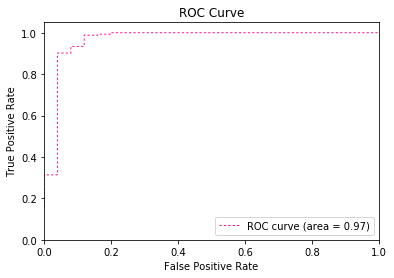

In [53]:
#Plot ROC for the entire test dataset
probs = logreg.predict_proba(test_data)
fpr, tpr, _ = roc_curve(test_labels, probs[:, 1])
roc_auc = auc(fpr, tpr)

# Plot all ROC curves
plt.figure()
plt.plot(fpr, tpr,
         label='ROC curve (area = {0:0.2f})'
               ''.format(roc_auc),
         color='deeppink', linestyle=':', linewidth=1)

plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve')
plt.legend(loc="lower right")
plt.show()